In [273]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.metrics import pairwise_distances
%matplotlib inline

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

city_info = pd.read_csv('FINAL_DATASETS/NORM.csv')

In [275]:
city_numeric = city_info.select_dtypes(include=[np.number]).drop(['county_fips'], 1)
city_numeric_data = city_numeric.values

cities = city_info['city'].to_list()
states = city_info['state_id'].to_list()

In [276]:
def get_initial_centroids(data, k, seed=None):
    """
    Randomly choose k data points as initial centroids
    """
    if seed is not None: 
        np.random.seed(seed)
        
    size = data.shape[0] 
        
    rand_indices = np.random.randint(0, size, k)
  
    centroids = data[rand_indices,:]
    
    return centroids

In [277]:
def assign_clusters(data, centroids):
    """
    Parameters:  
      - data      - is an np.array of float values of length N.  
      - centroids - is an np.array of float values of length k.

    Returns  
      -  A np.array of length N where the ith index represents which centroid 
         data[i] was assigned to. The assignments range between the values 0, ..., k-1.
    """
    return np.argmin(pairwise_distances(data, centroids), axis=1)

In [278]:
def revise_centroids(data, k, cluster_assignment):
    """
    Parameters:  
      - data               - is an np.array of float values of length N.
      - k                  - number of centroids
      - cluster_assignment - np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to. The assignments range between the values 0, ..., k-1.

    Returns  
      -  A np.array of length k for the new centroids.
    """
    new_centroids = []
    for i in range(k):
        
        member_data_points = data[cluster_assignment == i]
        centroid = np.mean(member_data_points, axis=0)
        centroid = centroid.flatten()
        new_centroids.append(centroid)
        
    new_centroids = np.array(new_centroids)
    return new_centroids

In [279]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    """
    Computes the heterogeneity metric of the data using the given centroids and cluster assignments.
    """
    heterogeneity = 0.0
    for i in range(k):
        
        member_data_points = data[cluster_assignment==i,:]
        
        if member_data_points.shape[0] > 0:
            # Compute distances from centroid to data point
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [280]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    """
    runs k-means on given data and initial set of centroids.
    
    Parameters:  
      - data                 - is an np.array of float values of length N.
      - k                    - number of centroids
      - initial_centroids    - is an np.array of float values of length k.
      - maxiter              - maximum number of iterations to run the algorithm
      - record_heterogeneity - if provided an empty list, it will compute the heterogeneity 
                               at each iteration and append it to the list. 
      - verbose              - set to True to display progress. Defaults to False and won't 
                               display progress.

    Returns  
      - centroids - A np.array of length k for the centroids upon termination of the algorithm.
      - cluster_assignment - A np.array of length N where the ith index represents which 
                             centroid data[i] was assigned to.
    """
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):  
        if verbose:
            print(itr)
        
        cluster_assignment = assign_clusters(data, centroids)
            
        centroids = revise_centroids(data, k, cluster_assignment)
            
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment == cluster_assignment).all():
            break
        
        if prev_cluster_assignment is not None:
            num_changed = sum(abs(prev_cluster_assignment - cluster_assignment))
            if verbose:
                print('{} elements changed their cluster assignment.'.format(num_changed))  
        
        if record_heterogeneity is not None:
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [281]:
def plot_heterogeneity(heterogeneity, k):
    """
    Plots how the heterogeneity changes as the number of iterations increases.
    """
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
163 elements changed their cluster assignment.
2
137 elements changed their cluster assignment.
3
91 elements changed their cluster assignment.
4
46 elements changed their cluster assignment.
5
33 elements changed their cluster assignment.
6
16 elements changed their cluster assignment.
7
15 elements changed their cluster assignment.
8
5 elements changed their cluster assignment.
9
9 elements changed their cluster assignment.
10
3 elements changed their cluster assignment.
11
4 elements changed their cluster assignment.
12


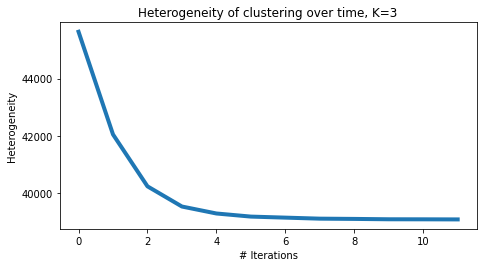

In [282]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(city_numeric_data, k, seed=0)
centroids, cluster_assignment = kmeans(city_numeric_data, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [283]:
def smart_initialize(data, k, seed=None):
    """
    k-means++
    """
    if seed is not None: 
        np.random.seed(seed)
        
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:]
    
    # Compute distances from the first centroid chosen to all the other data points
    distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()
    
    for i in range(1, k):
        idx = np.random.choice(data.shape[0], 1, p=distances/sum(distances))
        centroids[i] = data[idx,:]

        distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean'),axis=1)
    
    return centroids

In [284]:
def kmeans_multiple_runs(data, k, maxiter, seeds, verbose=False):
    """
    Runs kmeans multiple times 
    
    Parameters:  
      - data    - is an np.array of float values of length N.
      - k       - number of centroids
      - maxiter - maximum number of iterations to run the algorithm
      - seeds   - Either number of seeds to try (generated randomly) or a list of seed values
      - verbose - set to True to display progress. Defaults to False 
    
    Returns  
      - final_centroids          - A np.array of length k for the centroids upon 
                                   termination of the algorithm.
      - final_cluster_assignment - A np.array of length N where the ith index represents which 
                                   centroid data[i] was assigned to. 
    """    
    min_heterogeneity_achieved = float('inf')
    final_centroids = None
    final_cluster_assignment = None
    if type(seeds) == int:
        seeds = np.random.randint(low=0, high=10000, size=seeds)
    
    num_runs = len(seeds)
    
    for seed in seeds:

        initial_centroids = smart_initialize(data, k, seed=seed)
        
        centroids, cluster_assignment = kmeans(data, k, initial_centroids, maxiter)

        seed_heterogeneity = compute_heterogeneity(data, k, centroids, cluster_assignment)
        
        if verbose:
            print('seed={}, heterogeneity={}'.format(seed, seed_heterogeneity))
            sys.stdout.flush()

        if seed_heterogeneity < min_heterogeneity_achieved:
            min_heterogeneity_achieved = seed_heterogeneity
            final_centroids = centroids
            final_cluster_assignment = cluster_assignment
    
    # Return the centroids and cluster assignments that minimize heterogeneity.
    return final_centroids, final_cluster_assignment

Running k = 100
seed=20000, heterogeneity=9226.261180355266
seed=40000, heterogeneity=9336.855144710114
seed=80000, heterogeneity=8973.68100972186
Running k = 200
seed=20000, heterogeneity=4602.338220587495
seed=40000, heterogeneity=4650.268378563799
seed=80000, heterogeneity=4677.14423028298
Running k = 250
seed=20000, heterogeneity=3308.420843525439
seed=40000, heterogeneity=3406.627971735257
seed=80000, heterogeneity=3476.3092644427343


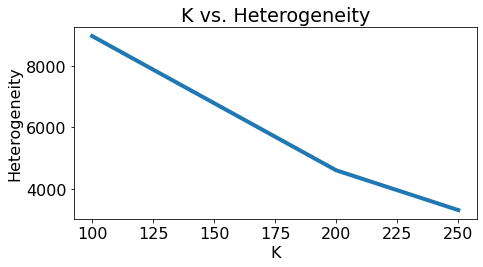

In [285]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    """
    Given list of k-values and their heterogeneities, will make a plot
    showing how heterogeneity varies with k.
    """
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

all_centroids = {}
all_cluster_assignment = {}
heterogeneity_values = []
seeds = [20000, 40000, 80000]
k_list = [100, 200, 250]

for k in k_list:
    print('Running k = {}'.format(k))
    heterogeneity = []
    all_centroids[k], all_cluster_assignment[k] = kmeans_multiple_runs(city_numeric_data, k, maxiter=400,
                                                                       seeds=seeds, verbose=True)
    score = compute_heterogeneity(city_numeric_data, k, all_centroids[k], all_cluster_assignment[k])
    heterogeneity_values.append(score)

plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In [287]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=100, random_state=0).fit(city_numeric_data)

np.set_printoptions(threshold=np.inf)
kmeans.labels_

array([ 5, 63,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 33,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8, 63, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 22, 22, 22, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        9, 54, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 22, 22, 22,
       22, 22, 38, 22, 22, 22, 22, 33, 33, 33, 33, 33,  2, 33, 33, 33, 12,
       12, 74, 54, 54, 54, 54, 54, 54, 76, 41, 77, 76, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 39, 75, 75, 13, 55, 55, 55, 55, 55, 55, 74,
       74, 74, 81, 81, 81, 25, 25,  9, 76, 76, 94, 94, 23, 23, 29, 29, 29,
       29, 29, 41, 41, 41, 41, 41, 76, 76, 76, 76,  4, 52, 14, 36, 36, 36,
       36, 36, 36, 36,  0,  1, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 39,
       39, 39, 39, 39, 39, 39, 39, 74, 74,  0,  9, 74, 37, 37, 76, 69, 69,
       69, 69, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53

In [290]:
all_clusters = {}

for i in k_list:
    d = {'city': cities, 'state' : states, 'cluster': all_cluster_assignment[i]}
    all_clusters[i] = pd.DataFrame(data=d).sort_values(by=['cluster']);

for i in k_list:
    all_clusters[i].to_csv('output/{}clusters.csv'.format(i), index=False)

In [291]:
d2 = {'city': cities, 'state' : states, 'cluster': kmeans.labels_}
pd.DataFrame(data=d2).sort_values(by=['cluster']).to_csv('output/sklearn100clusters.csv', index=False)


In [292]:
features = pd.DataFrame(kmeans.cluster_centers_[:, 59:72], range(0, 100), city_numeric.columns.tolist()[59:72])
features['clusterId'] = features.index
print(features.head())
features.shape

   size_feature  diversity_feature  education_feature  wealth_feature  \
0     -0.099129           0.982814          -0.036140       -0.396385   
1     -0.071818          -0.614671           0.187623       -0.261184   
2     -0.198959           1.138780           0.621243        1.386196   
3     -0.083601           0.918267          -1.691771       -1.072819   
4      0.115936          -1.406691           1.219668        0.039264   

   home_price_feature  urban_feature  political_feature  weather_feature  \
0            0.405909      -0.709361           0.811702         1.713516   
1           -1.185595      -0.024427          -1.355822         0.118793   
2            0.658024      -0.709361           1.056752         0.361698   
3           -0.452266       0.660507          -0.122917         0.629686   
4           -1.020994       0.660507          -0.831901        -0.952100   

   covid_feature  profession_feature  transportation_feature  poverty_feature  \
0       1.212077       

(100, 14)

In [293]:
city_info['clusterId'] = kmeans.labels_
print(city_info.head())

            city state_name_x state_id              county       lat  \
0       New York     New York       NY     New York County  0.693878   
1    Los Angeles   California       CA  Los Angeles County -0.546429   
2     Long Beach   California       CA  Los Angeles County -0.605953   
3  Santa Clarita   California       CA  Los Angeles County -0.489205   
4       Glendale   California       CA  Los Angeles County -0.533631   

        lng  city_population  county_fips  county_population   density  ...  \
0  1.429400        20.190928     0.737467           0.029153  5.385943  ...   
1 -1.195921         9.422179    -1.022265           3.666598  0.970706  ...   
2 -1.181797         0.730182    -1.022265           3.666598  1.117307  ...   
3 -1.201209         0.113184    -1.022265           3.666598 -0.284007  ...   
4 -1.186477         0.079385    -1.022265           3.666598  0.524969  ...   

   home_price_feature  urban_feature  political_feature  weather_feature  \
0            3.1

In [294]:
city_info.to_csv('FINAL_DATASETS/city_info.csv', index=False)
features.to_csv('FINAL_DATASETS/feature_vectors.csv', index=False)

In [296]:
d = { 'similarity' : [np.dot(features.values[i, 0:13], [-0.1, 0.8, 0, 0,0,0,0,0,0,0,0,0,0]) for i in range(100)]}
similarity = pd.DataFrame(data=d)
similarity['clusterId'] = similarity.index

similarity = similarity.sort_values(by='similarity', ascending=False)
similarity

,similarity,clusterId
43,1.110825,43
29,1.004281,29
2,0.930920,2
33,0.907827,33
15,0.904766,15
...,...,...
95,-1.570088,95
80,-1.621322,80
13,-1.634438,13
97,-2.083120,97


In [297]:
def recommendations(user, city_info, features, num_recs=15):
    
    """
    Returns the top num_recs recommendations for a given feature vector

    Parameters:
        -user: the user vector
        -city_info: the dataframe with all the city/state/cluster data
        -features: the dataframe with the cluster feature vectors
        -num_recs: the number of recommendations to return (default: 15)

    Returns:
        -A list of ranked cities and states
        -Distances from each city that was selected
    """

    city_numeric = city_info.select_dtypes(include=[np.number]).drop(['county_fips'], 1).values
    current_recs = 0
    i = 0
    list_recs = []
    distances = []
    city_index = []

    d = { 'similarity' : [np.dot(features.values[i, 0:13], user) for i in range(100)]}
    similarity = pd.DataFrame(data=d)
    similarity['clusterId'] = similarity.index
    similarity = similarity.sort_values(by='similarity', ascending=False)

    data = pd.DataFrame(city_info[['city', 'state_id', 'clusterId']])
    data['index'] = data.index

    while(current_recs < num_recs):
        cluster = data[data['clusterId'] == similarity['clusterId'].iloc[i]][['index', 'city', 'state_id']]
        for k in range(cluster.shape[0]):
            list_recs.append(cluster.iloc[k, :].loc[['city', 'state_id']].values)
            city_index.append(cluster.iloc[k, :].loc['index'])
        
        i = i + 1
        current_recs = len(list_recs)

    
    for i in range(len(city_index)):
        distances.append(np.dot(user, city_numeric[city_index[i], 59:72]) / (np.linalg.norm(user) * np.linalg.norm(city_numeric[city_index[i], 59:72])))

    return list_recs[0:num_recs], distances[0:num_recs]

In [298]:
ranks, dist = recommendations([20.190927728768347, 1.0091730527359162, 1.4503402636473703, 4.847562853752599, 3.1970452855026603, -0.7093612041659976, 2.3091925427444657, -0.6310433948605275, 0.21845095047502544, 0.7564549159594699, 9.868185854992472, 0.4909793205552405, 0.8445357765751516], city_info, features)

In [299]:
print_full(ranks)
print_full(dist)

[array(['New York', 'NY'], dtype=object), array(['Los Angeles', 'CA'], dtype=object), array(['Chicago', 'IL'], dtype=object), array(['San Francisco', 'CA'], dtype=object), array(['Boston', 'MA'], dtype=object), array(['Revere', 'MA'], dtype=object), array(['Jersey City', 'NJ'], dtype=object), array(['Bayonne', 'NJ'], dtype=object), array(['Union City', 'NJ'], dtype=object), array(['West New York', 'NJ'], dtype=object), array(['Hoboken', 'NJ'], dtype=object), array(['Yonkers', 'NY'], dtype=object), array(['New Rochelle', 'NY'], dtype=object), array(['Mount Vernon', 'NY'], dtype=object), array(['White Plains', 'NY'], dtype=object)]
[1.0, 0.8671261646036245, 0.9480970797874413, 0.6734710364867327, 0.6021023389344339, 0.3965572638042058, 0.4881680220342212, 0.42494659754002523, 0.42595329718265934, 0.4209694109295478, 0.4247872752159984, 0.4275656187009803, 0.38224551820677094, 0.37802498817243146, 0.34901525085903334]
